<a href="https://colab.research.google.com/github/Doometnick/Distributed-TPU-Training/blob/master/Distributed_TPU_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ready for some speed?

Google Colab offers options to use GPUs and TPUs as hardware accelerators. While this can already significantly increase the training speed, distributing trainig over a pool of these accelerators, we can increase the speed even further.



--> To enable TPUs, go to **'Runtime' > 'Change runtime type'** on the top left, and enable **TPU** as hardware accelerator.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")

TensorFlow 2.x selected.
Tensorflow version: 2.0.0


In [0]:
import numpy as np
import functools
import os
import matplotlib.pyplot as plt

###Data
We will use the mnist data set to demonstrate distributed training.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scale to [0,1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add dimension so we have a shape of (28, 28, 1) for every picture.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f"x_train shape: {x_train.shape}")

# Convert to float32 is necessary for the model.fit() below.
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

x_train shape: (60000, 28, 28, 1)


### Model

In [0]:
def build_model():

    n_filters = 64
    wdecay = 0.001

    # We use functools to create partial functions so the 
    # model definition below becomes more readable.
    Activation = functools.partial(tf.keras.layers.Activation, activation="relu")
    Conv2D = functools.partial(tf.keras.layers.Conv2D, 
                               activation=None, 
                               padding="same", 
                               kernel_regularizer=tf.keras.regularizers.l2(wdecay))
    MaxPool = functools.partial(tf.keras.layers.MaxPool2D, pool_size=(2,2))
    Flatten = tf.keras.layers.Flatten
    Dense = tf.keras.layers.Dense
    BatchNormalization = tf.keras.layers.BatchNormalization
    Dropout = tf.keras.layers.Dropout

    model = tf.keras.Sequential([
        
        # Use three subsequent Conv2D layers without pooling in between
        # to have a more discriminative decision function 
        # (https://arxiv.org/abs/1409.1556).
        Conv2D(filters=n_filters*1, kernel_size=(3,3), strides=(1,1), input_shape=x_train.shape[1:]),
        BatchNormalization(),
        Activation(),
        Conv2D(filters=n_filters*1, kernel_size=(3,3), strides=(1,1)),
        BatchNormalization(),
        Activation(),
        Conv2D(filters=n_filters*1, kernel_size=(3,3), strides=(1,1)),
        BatchNormalization(),
        Activation(),
        MaxPool(),
        

        Conv2D(filters=n_filters*2, kernel_size=(3,3), strides=(1,1)),
        BatchNormalization(),
        Activation(),
        Conv2D(filters=n_filters*2, kernel_size=(3,3), strides=(1,1)),
        BatchNormalization(),
        Activation(),
        Conv2D(filters=n_filters*2, kernel_size=(3,3), strides=(1,1)),
        BatchNormalization(),
        Activation(),
        MaxPool(),

        Flatten(),

        Dense(64, activation=None, kernel_regularizer=tf.keras.regularizers.l2(wdecay)),
        Dropout(0.5),
        BatchNormalization(),
        Activation(),

        Dense(10, activation="softmax")
    ])

    return model

In [0]:
def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10))
    model.add(tf.keras.layers.Activation('softmax'))
    return model

Here we define the distribution strategy.

In [6]:
# Cluster resolver for tf 2.0, see
# https://www.tensorflow.org/guide/distributed_training#tpustrategy
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
tpu_strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)

with tpu_strategy.scope():
  model = create_model()
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy', 'sparse_categorical_accuracy'])

INFO:tensorflow:Initializing the TPU system: 10.106.219.210:8470


INFO:tensorflow:Initializing the TPU system: 10.106.219.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


And then we train the model for 15 episodes. Note that the training speed per episode is very high.

In [7]:
# How often do we validate, as this decreases the training speed on distributed TPUs.
validation_frequency = 5

history = model.fit(x_train, 
                    y_train,
                    epochs=15,
                    steps_per_epoch=100,
                    validation_data=(x_test, y_test),
                    validation_freq=validation_frequency)

Train on 100 steps, validate on 17 steps
Epoch 1/15
100/100 [==============================] - 12s 120ms/step - loss: 0.7702 - accuracy: 0.8264 - sparse_categorical_accuracy: 0.8264
Epoch 2/15
100/100 [==============================] - 2s 21ms/step - loss: 0.1276 - accuracy: 0.9621 - sparse_categorical_accuracy: 0.9621
Epoch 3/15
100/100 [==============================] - 2s 21ms/step - loss: 0.0874 - accuracy: 0.9736 - sparse_categorical_accuracy: 0.9736
Epoch 4/15
100/100 [==============================] - 2s 21ms/step - loss: 0.0692 - accuracy: 0.9800 - sparse_categorical_accuracy: 0.9800
Epoch 5/15
100/100 [==============================] - 6s 58ms/step - loss: 0.0555 - accuracy: 0.9834 - sparse_categorical_accuracy: 0.9834 - val_loss: 0.0446 - val_accuracy: 0.9859 - val_sparse_categorical_accuracy: 0.9859
Epoch 6/15
100/100 [==============================] - 2s 20ms/step - loss: 0.0471 - accuracy: 0.9859 - sparse_categorical_accuracy: 0.9859
Epoch 7/15
100/100 [===================

###Performance

We achieve a very high validation accuracy (>99%) within approx 5 epochs. Since our validation happens only every 5 epochs, the training continues for 10 epochs so that we can see some evolvement of validation loss and accuracy below. 

In [0]:
def plot_training_history(history, title=None):
    fig = plt.figure(figsize=(9,9))
    plt.plot(history['accuracy'], label='acc')
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_accuracy'], label='val_acc')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    if title is not None:
        plt.suptitle(title)

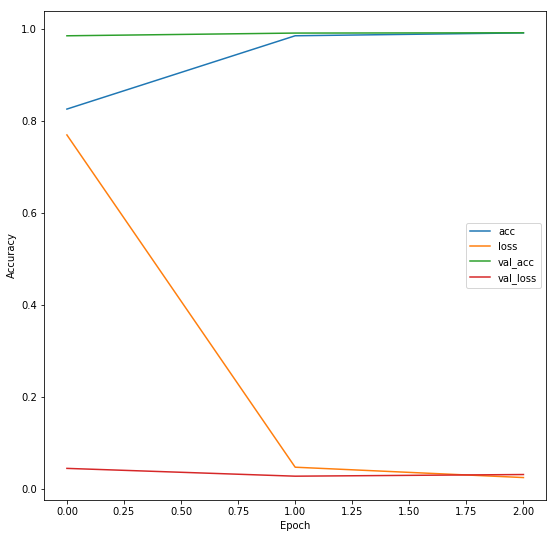

In [9]:
# Align metrics for validation frequency, since training was done five times
# more often than validation.
for metric in ["loss", "accuracy", "sparse_categorical_accuracy"]:
    metric_series = history.history[metric]
    history.history[metric] = [metric_series[i] for i in range(0, len(metric_series), validation_frequency)]

plot_training_history(history.history)